# Capstone project: Function 6

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,RationalQuadratic, Matern, WhiteKernel
import matplotlib.pyplot as plt
import sklearn
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting
from scipy.interpolate import griddata
from sklearn.preprocessing import MinMaxScaler
from bayes_opt import BayesianOptimization, UtilityFunction
from scipy.stats import norm

ModuleNotFoundError: No module named 'bayes_opt'

Note: you may need to restart the kernel to use updated packages.


## Description of function 6

You’re optimising a cake recipe using a black-box function with five ingredient inputs, for example flour, sugar, eggs, butter and milk. Each recipe is evaluated with a combined score based on flavour, consistency, calories, waste and cost, where each factor contributes negative points as judged by an expert taster. This means the total score is negative by design. 

To frame this as a maximisation problem, your goal is to bring that score as close to zero as possible or, equivalently, to maximise the negative of the total sum.

Input array 5D (20,5) output array 1D (20,1)

### Step 1: Load data

In [2]:
X = np.load('initial_inputs.npy')
y = np.load('initial_outputs.npy')

inputdata = np.load('initial_inputs.npy')
outputdata = np.load('initial_outputs.npy')

print(X,y)
np.shape(y)

[[0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]
 [0.24238435 0.84409997 0.5778091  0.67902128 0.50195289]
 [0.72952261 0.7481062  0.67977464 0.35655228 0.67105368]
 [0.77062024 0.11440374 0.04677993 0.64832428 0.27354905]
 [0.6188123  0.33180214 0.18728787 0.75623847 0.3288348 ]
 [0.78495809 0.91068235 0.7081201  0.95922543 0.0049115 ]
 [0.14511079 0.8966846  0.89632223 0.72627154 0.23627199]
 [0.94506907 0.28845905 0.97880576 0.96165559 0.59801594]
 [0.12572016 0.86272469 0.02854433 0.24660527 0.75120624]
 [0.75759436 0.35583141 0.0165229  0.4342072  0.11243304]
 [0.5367969  0.30878091 0.41187929 0.38822518 0.5225283 ]
 [0.95773967 0.23566857 0.09914585 0.15680593 0.07131737]
 [0.6293079  0.80348368 0.81140844 0.04561319 0.11062446]
 [0.02173531 0.42808424 0.83593944 0.48948866 0.51108173]
 [0.43934426 0.69892383 0.42682022 0.10947609 0.87788847]
 [0.25890557 0.79367771 0.6421139  0.19667346 0.59310318]
 [0.43216593 0.71561781 0.3418191  0.70499988 0.61496184]
 [0.78287982 0

(20,)

### Step 2: Fit a surrogate model - Gaussian processes

In [7]:
kernel = Matern(length_scale=np.ones(5)*0.3, nu=2.5) + WhiteKernel(noise_level=1e-3)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True, random_state=0)
gp.fit(X, y)

GaussianProcessRegressor(kernel=Matern(length_scale=[0.3, 0.3, 0.3, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.001),
                         n_restarts_optimizer=5, normalize_y=True,
                         random_state=0)

In [8]:

# Wrap the trained Gaussian Process (GP) model into a simple callable function that bayes_opt can use.

def gp_predict(x1, x2, x3, x4, x5):
    X_new = np.array([[x1, x2, x3, x4, x5]])
    mu = gp.predict(X_new, return_std=False)[0]
    return mu

# Defines the search space boundaries for each ingredient (hyperparameter). E.g., we know that values in X fall between 0 and 1

pbounds = {
    'x1': (0,1), 'x2': (0,1), 'x3': (0,1), 'x4': (0,1), 'x5': (0,1)
}

### Step 3: Fit the acquisition parameter

In [9]:
#Initialise the optimiser using the gp predict function as the surrogate

optimizer = BayesianOptimization(
    f=gp_predict,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)


optimizer.maximize(
    init_points=0,  # we already have existing data
    n_iter=5        # number of new candidates to suggest
)

|   iter    |  target   |    x1     |    x2     |    x3     |    x4     |    x5     |
-------------------------------------------------------------------------------------
| 1         | -1.128932 | 0.3745401 | 0.9507143 | 0.7319939 | 0.5986584 | 0.1560186 |
| 2         | -1.857822 | 1.0       | 0.0       | 0.0       | 0.0       | 1.0       |
| 3         | -1.383837 | 0.7479275 | 0.3977958 | 0.3350699 | 0.8209825 | 0.5806566 |
| 4         | -1.245934 | 0.0575787 | 0.6049417 | 1.0       | 1.0       | 0.0       |
| 5         | -1.478819 | 0.0       | 1.0       | 0.0       | 1.0       | 0.0       |
| 6         | -1.536829 | 0.9642023 | 1.0       | 1.0       | 0.9169460 | 0.0       |


### Step 4: Identify next logical number

In [10]:
print("\n=== Next best recipe suggestion ===")
print(optimizer.max['params'])
print("Predicted score:", optimizer.max['target'])


=== Next best recipe suggestion ===
{'x1': np.float64(0.3745401188473625), 'x2': np.float64(0.9507143064099162), 'x3': np.float64(0.7319939418114051), 'x4': np.float64(0.5986584841970366), 'x5': np.float64(0.15601864044243652)}
Predicted score: -1.128932723028438


# ******** Week 2: Update data and optimisation **********

## Step 1: Load in new data

In [3]:

inputdata = np.load('initial_inputs.npy')
outputdata = np.load('initial_outputs.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week1/inputs.txt', 'r') as f:
    inputs_week2 = f.read()

with open('../Inputs_Outputs/Week1/outputs.txt', 'r') as f:
    outputs_week2 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week2 = eval(inputs_week2, {"__builtins__": {}}, safe_globals)
outputs_week2 = eval(outputs_week2, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week2 = np.array(inputs_week2, dtype=object)
outputs_week2 = np.array(outputs_week2, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F6_inputs_week2 = inputs_week2[5]
F6_outputs_week2 = outputs_week2[5]



# Step 5: merge with previous data
F6_inputs_week2 = F6_inputs_week2.reshape(1, -1)
inputdata_week2 = np.concatenate((inputdata,F6_inputs_week2), axis=0)

outputdata_week2 = np.concatenate((outputdata,np.array([F6_outputs_week2])))

print(inputdata_week2)
print(outputdata_week2)

#Save output
np.save('inputs_week2.npy', inputdata_week2)
np.save('outputs_week2.npy', outputdata_week2)

[[0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]
 [0.24238435 0.84409997 0.5778091  0.67902128 0.50195289]
 [0.72952261 0.7481062  0.67977464 0.35655228 0.67105368]
 [0.77062024 0.11440374 0.04677993 0.64832428 0.27354905]
 [0.6188123  0.33180214 0.18728787 0.75623847 0.3288348 ]
 [0.78495809 0.91068235 0.7081201  0.95922543 0.0049115 ]
 [0.14511079 0.8966846  0.89632223 0.72627154 0.23627199]
 [0.94506907 0.28845905 0.97880576 0.96165559 0.59801594]
 [0.12572016 0.86272469 0.02854433 0.24660527 0.75120624]
 [0.75759436 0.35583141 0.0165229  0.4342072  0.11243304]
 [0.5367969  0.30878091 0.41187929 0.38822518 0.5225283 ]
 [0.95773967 0.23566857 0.09914585 0.15680593 0.07131737]
 [0.6293079  0.80348368 0.81140844 0.04561319 0.11062446]
 [0.02173531 0.42808424 0.83593944 0.48948866 0.51108173]
 [0.43934426 0.69892383 0.42682022 0.10947609 0.87788847]
 [0.25890557 0.79367771 0.6421139  0.19667346 0.59310318]
 [0.43216593 0.71561781 0.3418191  0.70499988 0.61496184]
 [0.78287982 0

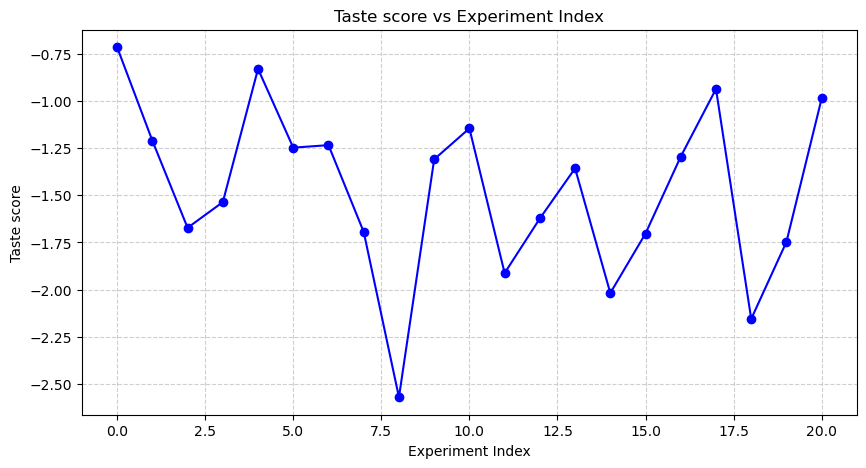

Best parameters: [0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]
Best score: -0.7142649478202404


In [15]:
### I want to get as close to zero as possible. Let's have a look at the outputs now


indices = np.arange(len(outputdata_week2))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week2, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Taste score')
plt.title('Taste score vs Experiment Index')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week2)
best_x = inputdata_week2[best_idx]
best_y = outputdata_week2[best_idx]

print("Best parameters:", best_x)
print("Best score:", best_y)

## Step 2: Fit a surrogate model with updated data

In [9]:
X_wk2 = inputdata_week2
y_wk2 = outputdata_week2

kernel = Matern(length_scale=np.ones(5)*0.3, nu=2.5) + WhiteKernel(noise_level=1e-3)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True, random_state=0)
gp.fit(X_wk2, y_wk2)

GaussianProcessRegressor(kernel=Matern(length_scale=[0.3, 0.3, 0.3, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.001),
                         n_restarts_optimizer=5, normalize_y=True,
                         random_state=0)

## Step 3: Fit an appropriate acquisition function

In [10]:
# Wrap the trained Gaussian Process (GP) model into a simple callable function that bayes_opt can use.

def gp_predict(x1, x2, x3, x4, x5):
    X_new = np.array([[x1, x2, x3, x4, x5]])
    mu = gp.predict(X_new, return_std=False)[0]
    return mu

# Defines the search space boundaries for each ingredient (hyperparameter). E.g., we know that values in X fall between 0 and 1

pbounds = {
    'x1': (0,1), 'x2': (0,1), 'x3': (0,1), 'x4': (0,1), 'x5': (0,1)
}


#Initialise the optimiser using the gp predict function as the surrogate

optimizer = BayesianOptimization(
    f=gp_predict,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)


optimizer.maximize(
    init_points=0,  # we already have existing data
    n_iter=5        # number of new candidates to suggest
)

|   iter    |  target   |    x1     |    x2     |    x3     |    x4     |    x5     |
-------------------------------------------------------------------------------------
| 1         | -1.004432 | 0.3745401 | 0.9507143 | 0.7319939 | 0.5986584 | 0.1560186 |
| 2         | -1.887666 | 1.0       | 0.0       | 0.0       | 0.0       | 1.0       |
| 3         | -1.402139 | 0.7479275 | 0.3977958 | 0.3350699 | 0.8209825 | 0.5806566 |
| 4         | -1.323345 | 0.0439577 | 1.0       | 1.0       | 1.0       | 0.0       |
| 5         | -0.982510 | 0.3646003 | 0.9514041 | 0.7236199 | 0.6361660 | 0.1070468 |
| 6         | -1.594114 | 0.0788629 | 1.0       | 0.0497622 | 0.5087986 | 0.0       |


In [14]:
rounded_params = {k: round(v, 6) for k, v in optimizer.max['params'].items()}
print(rounded_params)

# Round the predicted score
print("Predicted score:", round(optimizer.max['target'], 6))

{'x1': np.float64(0.3646), 'x2': np.float64(0.951404), 'x3': np.float64(0.72362), 'x4': np.float64(0.636166), 'x5': np.float64(0.107047)}
Predicted score: -0.982511


# ******** Week 3: Data update and optimisation ********

### Step 1: Update inputs and outputs for surrogate model

In [4]:
inputdata = np.load('inputs_week2.npy')
outputdata = np.load('outputs_week2.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week2/inputs.txt', 'r') as f:
    inputs_week3 = f.read()

with open('../Inputs_Outputs/Week2/outputs.txt', 'r') as f:
    outputs_week3 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week3 = eval(inputs_week3, {"__builtins__": {}}, safe_globals)
outputs_week3 = eval(outputs_week3, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week3 = np.array(inputs_week3, dtype=object)
outputs_week3 = np.array(outputs_week3, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F6_inputs_week3 = inputs_week3[5]
F6_outputs_week3 = outputs_week3[5]



# Step 5: merge with previous data
F6_inputs_week3 = F6_inputs_week3.reshape(1, -1)
inputdata_week3 = np.concatenate((inputdata,F6_inputs_week3), axis=0)

outputdata_week3 = np.concatenate((outputdata,np.array([F6_outputs_week3])))

print(inputdata_week3)
print(outputdata_week3)

#Save output
np.save('inputs_week3.npy', inputdata_week3)
np.save('outputs_week3.npy', outputdata_week3)

[[0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]
 [0.24238435 0.84409997 0.5778091  0.67902128 0.50195289]
 [0.72952261 0.7481062  0.67977464 0.35655228 0.67105368]
 [0.77062024 0.11440374 0.04677993 0.64832428 0.27354905]
 [0.6188123  0.33180214 0.18728787 0.75623847 0.3288348 ]
 [0.78495809 0.91068235 0.7081201  0.95922543 0.0049115 ]
 [0.14511079 0.8966846  0.89632223 0.72627154 0.23627199]
 [0.94506907 0.28845905 0.97880576 0.96165559 0.59801594]
 [0.12572016 0.86272469 0.02854433 0.24660527 0.75120624]
 [0.75759436 0.35583141 0.0165229  0.4342072  0.11243304]
 [0.5367969  0.30878091 0.41187929 0.38822518 0.5225283 ]
 [0.95773967 0.23566857 0.09914585 0.15680593 0.07131737]
 [0.6293079  0.80348368 0.81140844 0.04561319 0.11062446]
 [0.02173531 0.42808424 0.83593944 0.48948866 0.51108173]
 [0.43934426 0.69892383 0.42682022 0.10947609 0.87788847]
 [0.25890557 0.79367771 0.6421139  0.19667346 0.59310318]
 [0.43216593 0.71561781 0.3418191  0.70499988 0.61496184]
 [0.78287982 0

### Step 2: Plot the updated output results

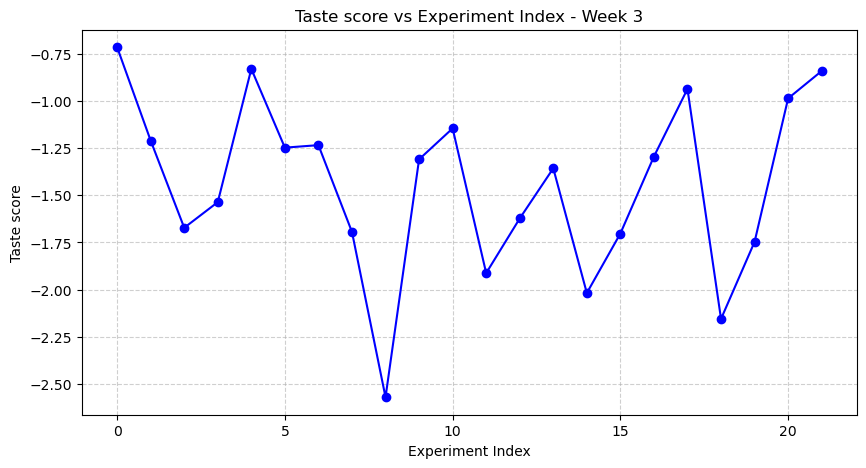

Best parameters: [0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]
Best score: -0.7142649478202404


In [5]:
### I want to get as close to zero as possible. Let's have a look at the outputs now

indices = np.arange(len(outputdata_week3))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week3, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Taste score')
plt.title('Taste score vs Experiment Index - Week 3')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week3)
best_x = inputdata_week3[best_idx]
best_y = outputdata_week3[best_idx]

print("Best parameters:", best_x)
print("Best score:", best_y)

### Step 3: Update surrogate model - Gaussian process

In [6]:
X_wk3 = inputdata_week3
y_wk3 = outputdata_week3

kernel = Matern(length_scale=np.ones(5)*0.3, nu=2.5) + WhiteKernel(noise_level=1e-3)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True, random_state=0)
gp.fit(X_wk3, y_wk3)

GaussianProcessRegressor(kernel=Matern(length_scale=[0.3, 0.3, 0.3, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.001),
                         n_restarts_optimizer=5, normalize_y=True,
                         random_state=0)

### Step 4: Fit update acuisition model - more balanced exploration / exploitation?

In [16]:
# Get current best
best_idx = np.argmax(y_wk3)
best_x = X_wk3[best_idx]
best_y = y_wk3[best_idx]
print("Current best y:", best_y, "at", best_x)

bounds = np.array([(0.0,1.0)]*5)  # shape (5,2); change as needed

def sample_candidates(n_candidates=5000, bounds=bounds, seed=None):
    rng = np.random.default_rng(seed)
    low = bounds[:,0]
    high = bounds[:,1]
    return rng.uniform(low=low, high=high, size=(n_candidates, bounds.shape[0]))

X_candidates = sample_candidates(n_candidates=5000, bounds=bounds, seed=0)

# Compute GP predictions and UCB
mu, sigma = gp.predict(X_candidates, return_std=True)
eps = 1e-9
sigma = np.maximum(sigma, eps)   # avoid div/NaN issues

kappa = 2.0   # 
ucb = mu + kappa * sigma

# Select next point(s) - single best
next_idx = np.argmax(ucb)
x_next = X_candidates[next_idx]
print("Next suggested point (single):", np.round(x_next,6), "UCB:", ucb[next_idx])

Current best y: -0.7142649478202404 at [0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]
Next suggested point (single): [0.397612 0.138363 0.749533 0.950433 0.051917] UCB: 0.022865728282089437


# ***** Week 4 - Update data *****

## Step 1 - Upload new data

In [2]:
inputdata = np.load('inputs_week3.npy')
outputdata = np.load('outputs_week3.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week3/inputs.txt', 'r') as f:
    inputs_week4 = f.read()

with open('../Inputs_Outputs/Week3/outputs.txt', 'r') as f:
    outputs_week4 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week4 = eval(inputs_week4, {"__builtins__": {}}, safe_globals)
outputs_week4 = eval(outputs_week4, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week4 = np.array(inputs_week4, dtype=object)
outputs_week4 = np.array(outputs_week4, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F6_inputs_week4 = inputs_week4[5]
F6_outputs_week4 = outputs_week4[5]



# Step 5: merge with previous data
F6_inputs_week4 = F6_inputs_week4.reshape(1, -1)
inputdata_week4 = np.concatenate((inputdata,F6_inputs_week4), axis=0)

outputdata_week4 = np.concatenate((outputdata,np.array([F6_outputs_week4])))

print(inputdata_week4)
print(outputdata_week4)

#Save output
np.save('inputs_week4.npy', inputdata_week4)
np.save('outputs_week4.npy', outputdata_week4)

[[0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]
 [0.24238435 0.84409997 0.5778091  0.67902128 0.50195289]
 [0.72952261 0.7481062  0.67977464 0.35655228 0.67105368]
 [0.77062024 0.11440374 0.04677993 0.64832428 0.27354905]
 [0.6188123  0.33180214 0.18728787 0.75623847 0.3288348 ]
 [0.78495809 0.91068235 0.7081201  0.95922543 0.0049115 ]
 [0.14511079 0.8966846  0.89632223 0.72627154 0.23627199]
 [0.94506907 0.28845905 0.97880576 0.96165559 0.59801594]
 [0.12572016 0.86272469 0.02854433 0.24660527 0.75120624]
 [0.75759436 0.35583141 0.0165229  0.4342072  0.11243304]
 [0.5367969  0.30878091 0.41187929 0.38822518 0.5225283 ]
 [0.95773967 0.23566857 0.09914585 0.15680593 0.07131737]
 [0.6293079  0.80348368 0.81140844 0.04561319 0.11062446]
 [0.02173531 0.42808424 0.83593944 0.48948866 0.51108173]
 [0.43934426 0.69892383 0.42682022 0.10947609 0.87788847]
 [0.25890557 0.79367771 0.6421139  0.19667346 0.59310318]
 [0.43216593 0.71561781 0.3418191  0.70499988 0.61496184]
 [0.78287982 0

## Step 2: Visualise the results

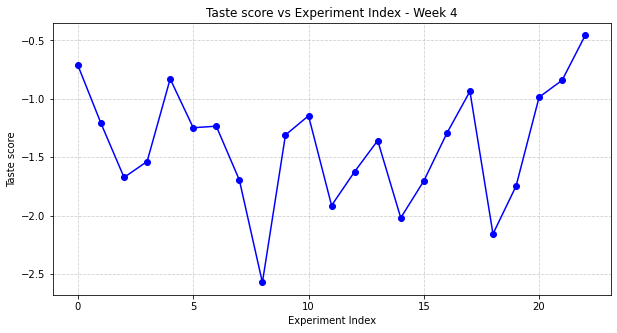

Best parameters: [0.397612 0.138363 0.749533 0.950433 0.051917]
Best score: -0.45640888124757395


In [3]:
### I want to get as close to zero as possible. Let's have a look at the outputs now

indices = np.arange(len(outputdata_week4))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week4, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Taste score')
plt.title('Taste score vs Experiment Index - Week 4')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week4)
best_x = inputdata_week4[best_idx]
best_y = outputdata_week4[best_idx]

print("Best parameters:", best_x)
print("Best score:", best_y)

## Step 3 - Fit new GP

In [4]:
X_wk4 = inputdata_week4
y_wk4 = outputdata_week4

kernel = Matern(length_scale=np.ones(5)*0.3, nu=2.5) + WhiteKernel(noise_level=1e-3)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True, random_state=0)
gp.fit(X_wk4, y_wk4)

GaussianProcessRegressor(kernel=Matern(length_scale=[0.3, 0.3, 0.3, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.001),
                         n_restarts_optimizer=5, normalize_y=True,
                         random_state=0)

## Step 4: Updated acquisition function

In [7]:
# Generate candidate recipes
X_candidates = np.random.rand(5000, 5)

# GP predictions
mu, sigma = gp.predict(X_candidates, return_std=True)



from scipy.stats import norm
# Expected Improvement acquisition
y_max = y_wk4.max()
sigma_nonzero = np.copy(sigma)
sigma_nonzero[sigma_nonzero == 0] = 1e-12
z = (mu - y_max) / sigma_nonzero
EI = (mu - y_max) * norm.cdf(z) + sigma * norm.pdf(z)
EI[sigma == 0] = 0.0

# Next recipe to try
x_next = X_candidates[np.argmax(EI)]
print("Next recipe to test:", np.round(x_next,6))

Next recipe to test: [0.534417 0.214575 0.678496 0.906823 0.025209]


# ****** Week 5 update *******

## Step 1: Load up data

In [2]:
inputdata = np.load('inputs_week4.npy')
outputdata = np.load('outputs_week4.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week4/inputs.txt', 'r') as f:
    inputs_week5 = f.read()

with open('../Inputs_Outputs/Week4/outputs.txt', 'r') as f:
    outputs_week5 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week5 = eval(inputs_week5, {"__builtins__": {}}, safe_globals)
outputs_week5 = eval(outputs_week5, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week5 = np.array(inputs_week5, dtype=object)
outputs_week5 = np.array(outputs_week5, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F6_inputs_week5 = inputs_week5[5]
F6_outputs_week5 = outputs_week5[5]



# Step 5: merge with previous data
F6_inputs_week5 = F6_inputs_week5.reshape(1, -1)
inputdata_week5 = np.concatenate((inputdata,F6_inputs_week5), axis=0)

outputdata_week5 = np.concatenate((outputdata,np.array([F6_outputs_week5])))

print(inputdata_week5)
print(outputdata_week5)

#Save output
np.save('inputs_week5.npy', inputdata_week5)
np.save('outputs_week5.npy', outputdata_week5)

[[0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]
 [0.24238435 0.84409997 0.5778091  0.67902128 0.50195289]
 [0.72952261 0.7481062  0.67977464 0.35655228 0.67105368]
 [0.77062024 0.11440374 0.04677993 0.64832428 0.27354905]
 [0.6188123  0.33180214 0.18728787 0.75623847 0.3288348 ]
 [0.78495809 0.91068235 0.7081201  0.95922543 0.0049115 ]
 [0.14511079 0.8966846  0.89632223 0.72627154 0.23627199]
 [0.94506907 0.28845905 0.97880576 0.96165559 0.59801594]
 [0.12572016 0.86272469 0.02854433 0.24660527 0.75120624]
 [0.75759436 0.35583141 0.0165229  0.4342072  0.11243304]
 [0.5367969  0.30878091 0.41187929 0.38822518 0.5225283 ]
 [0.95773967 0.23566857 0.09914585 0.15680593 0.07131737]
 [0.6293079  0.80348368 0.81140844 0.04561319 0.11062446]
 [0.02173531 0.42808424 0.83593944 0.48948866 0.51108173]
 [0.43934426 0.69892383 0.42682022 0.10947609 0.87788847]
 [0.25890557 0.79367771 0.6421139  0.19667346 0.59310318]
 [0.43216593 0.71561781 0.3418191  0.70499988 0.61496184]
 [0.78287982 0

## Step 2: Visualise results

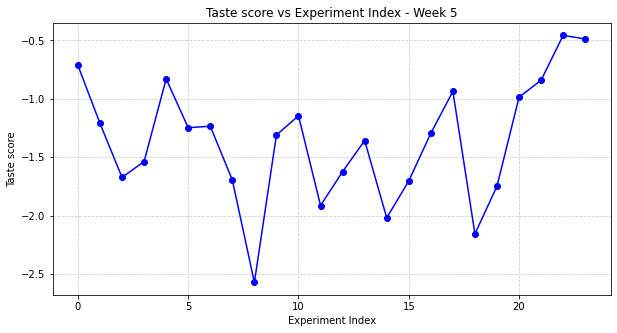

Best parameters: [0.397612 0.138363 0.749533 0.950433 0.051917]
Best score: -0.45640888124757395


In [3]:
### I want to get as close to zero as possible. Let's have a look at the outputs now

indices = np.arange(len(outputdata_week5))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week5, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Taste score')
plt.title('Taste score vs Experiment Index - Week 5')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week5)
best_x = inputdata_week5[best_idx]
best_y = outputdata_week5[best_idx]

print("Best parameters:", best_x)
print("Best score:", best_y)

## Step 3: Update GP surrogate model

In [4]:
X_wk5 = inputdata_week5
y_wk5 = outputdata_week5

kernel = Matern(length_scale=np.ones(5)*0.3, nu=2.5) + WhiteKernel(noise_level=1e-3)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True, random_state=0)
gp.fit(X_wk5, y_wk5)

GaussianProcessRegressor(kernel=Matern(length_scale=[0.3, 0.3, 0.3, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=0.001),
                         n_restarts_optimizer=5, normalize_y=True,
                         random_state=0)

## Step 4: Fit acquisition function

In [5]:
# Generate candidate recipes
X_candidates = np.random.rand(5000, 5)

# GP predictions
mu, sigma = gp.predict(X_candidates, return_std=True)



from scipy.stats import norm
# Expected Improvement acquisition
y_max = y_wk5.max()
sigma_nonzero = np.copy(sigma)
sigma_nonzero[sigma_nonzero == 0] = 1e-12
z = (mu - y_max) / sigma_nonzero
EI = (mu - y_max) * norm.cdf(z) + sigma * norm.pdf(z)
EI[sigma == 0] = 0.0

# Next recipe to try
x_next = X_candidates[np.argmax(EI)]
print("Next recipe to test:", np.round(x_next,6))

Next recipe to test: [0.435406 0.1921   0.498636 0.833297 0.06519 ]


# **** Week 6 *****

# Step 1: Upload updated data

In [2]:
inputdata = np.load('inputs_week5.npy')
outputdata = np.load('outputs_week5.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week5/inputs.txt', 'r') as f:
    inputs_week6 = f.read()

with open('../Inputs_Outputs/Week5/outputs.txt', 'r') as f:
    outputs_week6 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week6 = eval(inputs_week6, {"__builtins__": {}}, safe_globals)
outputs_week6 = eval(outputs_week6, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week6 = np.array(inputs_week6, dtype=object)
outputs_week6 = np.array(outputs_week6, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F6_inputs_week6 = inputs_week6[5]
F6_outputs_week6 = outputs_week6[5]



# Step 5: merge with previous data
F6_inputs_week6 = F6_inputs_week6.reshape(1, -1)
inputdata_week6 = np.concatenate((inputdata,F6_inputs_week6), axis=0)

outputdata_week6 = np.concatenate((outputdata,np.array([F6_outputs_week6])))

print(inputdata_week6)
print(outputdata_week6)

#Save output
np.save('inputs_week6.npy', inputdata_week6)
np.save('outputs_week6.npy', outputdata_week6)

[[0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]
 [0.24238435 0.84409997 0.5778091  0.67902128 0.50195289]
 [0.72952261 0.7481062  0.67977464 0.35655228 0.67105368]
 [0.77062024 0.11440374 0.04677993 0.64832428 0.27354905]
 [0.6188123  0.33180214 0.18728787 0.75623847 0.3288348 ]
 [0.78495809 0.91068235 0.7081201  0.95922543 0.0049115 ]
 [0.14511079 0.8966846  0.89632223 0.72627154 0.23627199]
 [0.94506907 0.28845905 0.97880576 0.96165559 0.59801594]
 [0.12572016 0.86272469 0.02854433 0.24660527 0.75120624]
 [0.75759436 0.35583141 0.0165229  0.4342072  0.11243304]
 [0.5367969  0.30878091 0.41187929 0.38822518 0.5225283 ]
 [0.95773967 0.23566857 0.09914585 0.15680593 0.07131737]
 [0.6293079  0.80348368 0.81140844 0.04561319 0.11062446]
 [0.02173531 0.42808424 0.83593944 0.48948866 0.51108173]
 [0.43934426 0.69892383 0.42682022 0.10947609 0.87788847]
 [0.25890557 0.79367771 0.6421139  0.19667346 0.59310318]
 [0.43216593 0.71561781 0.3418191  0.70499988 0.61496184]
 [0.78287982 0

## Step 2: Plot output data

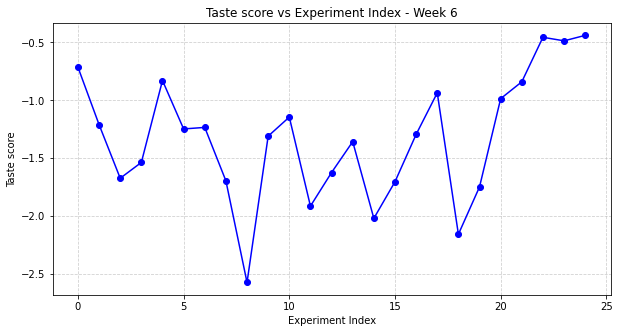

Best parameters: [0.435406 0.1921   0.498636 0.833297 0.06519 ]
Best score: -0.43973924953486


In [3]:
### I want to get as close to zero as possible. Let's have a look at the outputs now

indices = np.arange(len(outputdata_week6))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week6, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Taste score')
plt.title('Taste score vs Experiment Index - Week 6')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week6)
best_x = inputdata_week6[best_idx]
best_y = outputdata_week6[best_idx]

print("Best parameters:", best_x)
print("Best score:", best_y)

### Key things to change this time round

#### 1. Transform the output, e.g., reverse the negative so that bigger is better
#### 2. EI may not be appropriate in such high dimensional data - worth changing back to UCB
#### 3. The kernel is too smooth when the landscape is in fact rugged 


### How to implement changes

#### 1. Transform target output (larger = better, optimum is near zero  - this will help GP perform better)
#### 2. Use a rougher, anisotropic kernel this ensures that each ingredient has it's own sensitivity and captures sharp changes/ingredient interactions
#### 3. Replace EI with UCB

## Step 3: Transform target output and refit GP with smoother kernel

In [5]:
# Transform output (closer to zero is better)
X_wk6=inputdata_week6
y_wk6=outputdata_week6

y_transformed = -y_wk6

# Make kernel more anisotropic to allow for own sensitivity within each ingredient
kernel = Matern(
    length_scale=np.ones(5) * 0.3,
    length_scale_bounds=(1e-2, 2.0),
    nu=1.5
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-3,          # observation noise
    normalize_y=True,
    n_restarts_optimizer=10,
    random_state=0
)

gp.fit(X_wk6, y_transformed)

GaussianProcessRegressor(alpha=0.001,
                         kernel=Matern(length_scale=[0.3, 0.3, 0.3, 0.3, 0.3], nu=1.5),
                         n_restarts_optimizer=10, normalize_y=True,
                         random_state=0)

## Step 4: Acquisition function - change from EI to UCB

In [6]:
X_candidates = np.random.rand(8000, 5)

# -----------------------------
mu, sigma = gp.predict(X_candidates, return_std=True)
sigma = np.maximum(sigma, 1e-9)


# UCB acquisition
kappa = 1.0          # exploration
risk_penalty = 0.5   # robustness

acq = mu + kappa * sigma - risk_penalty * sigma


## Step 5: Apply a trust-region bias and find next candidates

In [7]:
best_idx = np.argmax(y_transformed)
x_best = X_wk6[best_idx]

dist = np.linalg.norm(X_candidates - x_best, axis=1)
acq *= np.exp(-dist / 0.5)

# Next candidates
x_next = X_candidates[np.argmax(acq)]
print("Next recipe to test:", np.round(x_next, 6))

Next recipe to test: [0.089213 0.95072  0.036294 0.14703  0.738956]


# ****** Week 7 ******

## Step 1: Upload updated data

In [4]:
inputdata = np.load('inputs_week6.npy')
outputdata = np.load('outputs_week6.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week6/inputs.txt', 'r') as f:
    inputs_week7 = f.read()

with open('../Inputs_Outputs/Week6/outputs.txt', 'r') as f:
    outputs_week7 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week7 = eval(inputs_week7, {"__builtins__": {}}, safe_globals)
outputs_week7 = eval(outputs_week7, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week7 = np.array(inputs_week7, dtype=object)
outputs_week7 = np.array(outputs_week7, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F6_inputs_week7 = inputs_week7[5]
F6_outputs_week7 = outputs_week7[5]



# Step 5: merge with previous data
F6_inputs_week7 = F6_inputs_week7.reshape(1, -1)
inputdata_week7 = np.concatenate((inputdata,F6_inputs_week7), axis=0)

outputdata_week7 = np.concatenate((outputdata,np.array([F6_outputs_week7])))

print(inputdata_week7)
print(outputdata_week7)

#Save output
np.save('inputs_week7.npy', inputdata_week7)
np.save('outputs_week7.npy', outputdata_week7)

[[0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]
 [0.24238435 0.84409997 0.5778091  0.67902128 0.50195289]
 [0.72952261 0.7481062  0.67977464 0.35655228 0.67105368]
 [0.77062024 0.11440374 0.04677993 0.64832428 0.27354905]
 [0.6188123  0.33180214 0.18728787 0.75623847 0.3288348 ]
 [0.78495809 0.91068235 0.7081201  0.95922543 0.0049115 ]
 [0.14511079 0.8966846  0.89632223 0.72627154 0.23627199]
 [0.94506907 0.28845905 0.97880576 0.96165559 0.59801594]
 [0.12572016 0.86272469 0.02854433 0.24660527 0.75120624]
 [0.75759436 0.35583141 0.0165229  0.4342072  0.11243304]
 [0.5367969  0.30878091 0.41187929 0.38822518 0.5225283 ]
 [0.95773967 0.23566857 0.09914585 0.15680593 0.07131737]
 [0.6293079  0.80348368 0.81140844 0.04561319 0.11062446]
 [0.02173531 0.42808424 0.83593944 0.48948866 0.51108173]
 [0.43934426 0.69892383 0.42682022 0.10947609 0.87788847]
 [0.25890557 0.79367771 0.6421139  0.19667346 0.59310318]
 [0.43216593 0.71561781 0.3418191  0.70499988 0.61496184]
 [0.78287982 0

## Step 2: Visualise the results

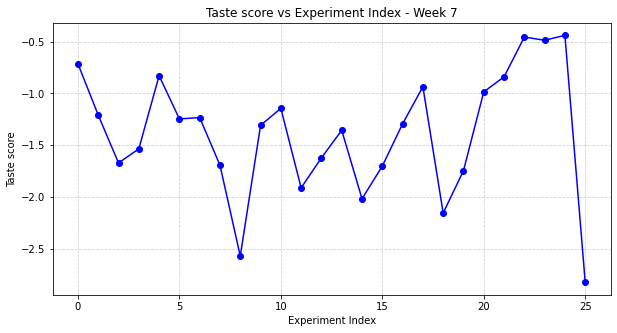

Best parameters: [0.435406 0.1921   0.498636 0.833297 0.06519 ]
Best score: -0.43973924953486


In [5]:
### I want to get as close to zero as possible. Let's have a look at the outputs now

indices = np.arange(len(outputdata_week7))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week7, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Taste score')
plt.title('Taste score vs Experiment Index - Week 7')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters 
best_idx = np.argmax(outputdata_week7)
best_x = inputdata_week7[best_idx]
best_y = outputdata_week7[best_idx]

print("Best parameters:", best_x)
print("Best score:", best_y)

## Things to try this week

### Point 1: Switch back to EI to see whether this improves things again

## Step 3: Update GP model

In [15]:
# Transform output (closer to zero is better)
X_wk7=inputdata_week7
y_wk7=outputdata_week7

y_transformed = -y_wk7

# Make kernel more anisotropic to allow for own sensitivity within each ingredient
kernel = Matern(
    length_scale=np.ones(5) * 0.3,
    length_scale_bounds=(1e-2, 2.0),
    nu=1.5
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-3,          # observation noise
    normalize_y=True,
    n_restarts_optimizer=10,
    random_state=0
)

gp.fit(X_wk7, y_transformed)

X_candidates = np.random.rand(8000, 5)


mu, sigma = gp.predict(X_candidates, return_std=True)
sigma = np.maximum(sigma, 1e-9)

## Step 4: Update acquisition function back to EI

In [17]:
from scipy.stats import norm

# -----------------------------
# Expected Improvement (EI)
# -----------------------------
y_best = np.max(y_transformed)

improvement = mu - y_best
Z = improvement / sigma

ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma == 0.0] = 0.0

# -----------------------------
# Select next point
# -----------------------------
x_next = X_candidates[np.argmax(ei)]

print("Next recipe to test:", np.round(x_next, 6))

Next recipe to test: [0.204688 0.902506 0.042975 0.002729 0.807407]
